   <center><h1>This is a dev and test environment for EMD1.0</h1></center>

In [1]:
import os.path
import re
import unicodedata
'''Responsible for Writing Customized NetLogo models for EMD'''
class NetLogoWriter:
    __original_model_path = ""
    __rule_injected_model_path = ""
    __EMD_line = -1000
    
    '''locate the NetLogo file, read it in, and identify the line to be experimented with as EMD_line.'''
    def __init__(self, model_string):
        self.__original_model_path = model_string
        #find EMD entry point
        with  open(self.__original_model_path, 'r') as file_reader:#should probably catch an exception here

            for i, line in enumerate(file_reader):
                if ";EMD:EvolveNextLine;" in line:
                    #print(i)
                    #print(line)
                    self.__EMD_line = i + 1
                
    '''if EMD annotation exists, then inject the new rule string'''
    def injectNewRule (self, new_rule):
        # with is like your try .. finally block in this case
        with open(self.__original_model_path, 'r') as file:  #should probably catch an exception here
            # read a list of lines into data
            data = file.readlines()
            file.close()
        self.__rule_injected_model_path = self.__original_model_path[:-5] + slugify(new_rule) + ".nlogo"
        if not (os.path.isfile(self.__rule_injected_model_path)):
            #print("Model already injected with this rule. Using cached version.")
            if self.__EMD_line >= 0:
                #print( "Your line: " + data[self.__EMD_line])
                data[self.__EMD_line] = new_rule
                # and write everything back
                with open(self.__rule_injected_model_path, 'w') as file:
                    file.writelines( data )
                    file.flush()
                    file.close()
        return self.__rule_injected_model_path
def slugify(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens."""
    value = str(re.sub('[^\w\s-]', '', value).strip().lower())
    value = str(re.sub('[-\s]+', '-', value))
    return value

In [2]:
import math 
import time
import nl4py
nl4py.startServer()
def EvaluateABM(modelname, setupCommands ,metricCommands, ticksToRun = -1):
    workspace = nl4py.newNetLogoHeadlessWorkspace()
    workspace.openModel(modelname)
    workspace.setParamsRandom()
    for setupCommand in setupCommands:
        workspace.command(setupCommand)
    #workspace.command("setup")
    if ticksToRun < 0:
        ticksToRun = math.pow(2,31)
    #print(metricCommands)
    workspace.scheduleReportersAndRun(metricCommands, 0,1,ticksToRun, "go")
    workspaceResults = workspace.getScheduledReporterResults()
    #print(workspaceResults)
    while len(workspaceResults) == 0:
        workspaceResults = workspace.getScheduledReporterResults()
    nl4py.getAllHeadlessWorkspaces().remove(workspace)
    workspace.deleteWorkspace()
    workspace = None
    return workspaceResults

Dependencies installed successfully! 
Start the NetLogoControllerServer using nl4py.startServer()
Shutting down old server instance...
Server started.


In [3]:
from deap import gp
from deap import creator
from deap import base
from deap import tools


def InjectRuleAndEvaluateABM(rule):
    rule = str(rule)
    modelPath='./models/Wolf Sheep Predation.nlogo'
    modelWriter = NetLogoWriter(modelPath)
    modelPath = modelWriter.injectNewRule(rule)
    print(modelPath)
    setup = ['set model-version "sheep-wolves-grass"', 'setup']
    measurementStrings = ["count sheep", "count wolves"]
    result = EvaluateABM(modelPath, setup, measurementStrings, 100)
    #aggregateMetric = abs(( int(float(result[-1][0])) / (float(result[-1][1]) + 0.0000001) ))
    aggregateMetric =  int(float(result[-1][1]))
    return aggregateMetric
class nlMinOneOf:
    __nlString = ""
    
    def __init__(self,comparator, agent_set):
            self.__nlString = " min-one-of ( " + str(agent_set) + " ) [ " + str(comparator)  + " ] "
    def __str__(self):
        return self.__nlString
    def __repr__(self):
        return self.__nlString
class nlComparator:
    __name__ = "color"
    def __init__(self,nlString):
        self.__name__ = str(nlString)
    def __str__(self):
        return self.__name__
    def __repr__(self):
        return self.__name__
    def getName():
        return __name__
class nlAgentSet:
    __name__ = "nobody"
    def __init__(self,nlString):
        self.__name__ = str(nlString)
    def __str__(self):
        return self.__name__
    def __repr__(self):
        return self.__name__
    def getName():
        return __name__
class nlAgent:
    __nlString = "nobody"
    def __init__(self,nlString):
        self.__nlString = nlString
    def __str__(self):
        return self.__nlString
    def __repr__(self):
        return self.__nlString
    
class emdModelPath:
    __nlString = ""
    def __init__(self,nlString):
        self.__nlString = nlString
    def __str__(self):
        return self.__nlString
    def __repr__(self):
        return self.__nlString
    
pset = gp.PrimitiveSetTyped("main", [], float)

#Terminals
agent_sets = ["sheep","wolves","turtles"]
for agent_set in agent_sets:    
    pset.addTerminal(nlAgentSet(agent_set), nlAgentSet,name = " '" + agent_set + "'")
pset.addPrimitive(nlAgentSet,[nlAgentSet],nlAgentSet)
comparator_str_set = ["energy", "distance myself"]
for comparator_str in comparator_str_set:    
    pset.addTerminal(nlComparator(comparator_str), nlComparator, name = " '" + comparator_str + "'")
pset.addPrimitive(nlComparator,[nlComparator],nlComparator)
pset.addTerminal("nobody",nlAgent)
pset.addTerminal(0,float)
#Primitives
pset.addPrimitive(InjectRuleAndEvaluateABM, [nlAgent], float)
pset.addPrimitive(nlMinOneOf, [nlComparator, nlAgentSet], nlAgent)

#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin,pset=pset)

#toolbox.register("expr", gp.genGrow, pset=pset, min_=1, max_=7)
#toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)


In [4]:
import numpy
from deap import algorithms
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
# Attribute generator
toolbox.register("expr_init", gp.genFull, pset=pset, min_=2, max_=4)
# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    function = gp.compile(individual, pset)
    return function,

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=2, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def main():
    #random.seed(69)
    
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 3, stats, halloffame=hof)
    
    return pop, hof, stats

In [6]:
pop, hof, stats = main()

./models/Wolf Sheep Predation.min-one-of-turtles-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-distance-myself.nlogo
./models/Wolf Sh

./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-wolves-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-

./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-turtles-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-distance-myself.nlogo
./models/Wolf Sheep Predation.min-one-of-sheep-energy.nlogo
./model

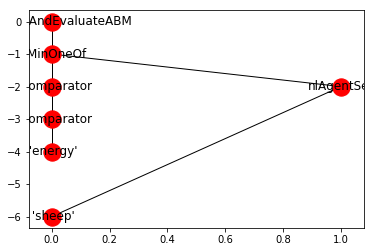

In [134]:
def custom_tree_layout(g):
    level = 0
    nodes_considered = set()
    nodes_considered.add(0)
    pos = {}
    pos[0] = numpy.array([0,0])
    while len(nodes_considered) != len(g.nodes):
        nodes_in_this_level = set()
        for node in g.nodes:
            for neighbor in g.neighbors(level):
                if neighbor not in nodes_considered:
                    nodes_in_this_level.add(neighbor)
        nodes_considered = nodes_in_this_level | nodes_considered
        level = level + 1
        for i,node in enumerate(nodes_in_this_level):
            pos[node] = numpy.array([(len(nodes_in_this_level) + i) - len(nodes_in_this_level),-level])
    return pos

nodes, edges, labels = gp.graph(expr)
import matplotlib.pyplot as plt
import networkx as nx
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = custom_tree_layout(g)
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()